### DS7337 NLP - HW 7
#### David Wei

# **Homework 7**

Cluster the reviews that you collected in homework 5, by doing the following:
1.	In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.  
2.	Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact. 
3.	Explain which of the two clustering results from question 1 is preferable (if one of them is), and why. 



In [1]:
# python
import os
import numpy as np
import re
import pandas as pd
from tqdm import tqdm
import string
import warnings
warnings.filterwarnings("ignore")
# viz & GUI
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn
from sklearn.preprocessing import minmax_scale
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# **Pre-Processing**
#### Loading in IMDB Movie Review Data via .pkl (Pickle) File
For how the pickled data was extracted, please refer to this the scraper code on [GitHub](https://github.com/chee154/NLP_study-py/blob/main/HW5_IMDB-Review-Scraper/DS7337%20NLP%20-%20HW%205%20-%20David%20Wei.ipynb). 

In [2]:
df = pd.read_pickle("HW5_IMDB_User_Review.pkl")
# remove the review_link
df = df[df.columns[~df.columns.isin(['movie_user_review_link'])]]
# print data
df.head(5)

,movie_title,movie_user_review_rating,movie_user_review_txt
0,Ad Astra,8,Let me start off by saying that the movie's pa...
1,Alien,10,"Alien is the pinnacle of sci-fi horror, and it..."
2,Star Wars: Episode IV - A New Hope,10,I can never pick a favorite movie because diff...
3,12 Monkeys,9,Twelve Monkeys is a science fiction movie dire...
4,Dark City,9,simply wonderful on every level. A matrix meet...


#### Vectorizing the Reviews Text

In [3]:
# get only the review from the dataframe
df_reviews = df['movie_user_review_txt']
# get the movie title
movie_titles = list(df['movie_title'])
# gets all the user reviews
user_review_ratings = df['movie_user_review_rating']

# init vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii', lowercase=True)

# vectorize
tf_idf = vectorizer.fit_transform(df_reviews)
print(tf_idf.shape)
print(type(tf_idf))

(100, 5215)
<class 'scipy.sparse.csr.csr_matrix'>


#### Converting Movie Review TF-IDF to Dataframe

In [4]:
def view_matrix(matrix, index_df):
    # convert document-term matrix to array 
    tfidf_array = matrix.toarray()
    # tokenize vectors to get the actual term (movie title) names
    tokens = vectorizer.get_feature_names()

    # doc_names = [f'book_{i+1}' for i, _ in enumerate(matrix)]
    doc_names = [index_df[i] for i, _ in enumerate(tfidf_array)]
    df = pd.DataFrame(data=tfidf_array, index=doc_names, columns=tokens)
    return df,tokens

### gets tokens
tfidf_tokens = view_matrix(tf_idf, movie_titles)[1]

##### creates tf-idf matrix df
tfidf_df = view_matrix(tf_idf, movie_titles)[0]
tfidf_df.reset_index(drop=True, inplace=True)

##### creates tf-idf matrix df with 'movie_user_review_rating'
tfdf_review_df = pd.concat([tfidf_df, user_review_ratings],axis=1)
tfdf_review_df.head(5)


,000,06,10,108,11,12,13,15,1500,16,...,yubb,zap,zaps,zed,zero,zimmer,zone,zoom,zooms,movie_user_review_rating
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
2,0.0,0.0,0.092749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


#### Reducing Sparse TF-IDF Matrix Dimensionality with LSA

In [5]:
from sklearn.decomposition import TruncatedSVD
from scipy import sparse as sp

# init SVD LSA
svd_clf = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
# store reduced dimension arrays
X_lsa = svd_clf.fit_transform(tfidf_df)
X_review_lsa = svd_clf.fit_transform(tfdf_review_df)
print(X_lsa.shape)

(100, 2)


# **Centroid Based Clustering w/K-Means**

### **Finding Optimal # of Clusters (k)**
After plotting the Elbow Method for finding optimal K we can see that there isn't really a distinguishable 'elbow' since it is almost linear. However, upon examing closer, we can see that at k=4 and k=6 has *slight* changes in slope so we will cluster using the max being k=6. 

In [6]:
def find_optimal_clusters(data, max_k):
    sse = []
    k_range = range(1,max_k+1)
    # get SSE for all cluster iterations
    for k in k_range:
        # init KMeans
        km = KMeans(n_clusters=k, init='k-means++',random_state=42,n_init=10, max_iter=250)
        km = km.fit(data)
        sse.append(km.inertia_)
    
    # plot Elbow Curve
    f, ax = plt.subplots(1, 1)
    ax.plot(k_range, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(k_range)
    ax.set_xticklabels(k_range)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')   

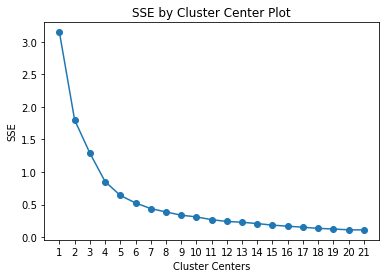

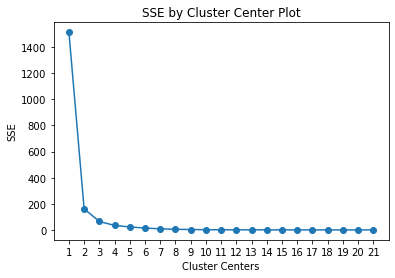

In [7]:
find_optimal_clusters(X_lsa, 21)
find_optimal_clusters(X_review_lsa, 21)

### **Scoring KMeans Clustering using Optimal K-Clusters (k=4)**

To evaluate how well the optimzed KMeans clustering performs, we will utilize the *Silhouette Coefficient* which provides us a goodness of fit score between -1 to 1 based on the separability between clusters based on the distances between and within clusters. 

In [8]:
from sklearn.metrics import silhouette_score

def kmeans_model(k, data):
    optimal_k = k
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++',random_state=42,n_init=10, max_iter=250)
    kmeans.fit(data)

    kmeans_labels = kmeans.labels_
    print(f'KMeans Silhouette Score (k={optimal_k}): {silhouette_score(data, kmeans_labels):.5f}')
    return kmeans_labels

print(f'{"-"*10}With LSA Applied{"-"*10}')
#### without user review
kmeans_1 = kmeans_model(2, X_lsa)
kmeans_2 = kmeans_model(4, X_lsa)

#### with user reviews
kmeans_3 = kmeans_model(2, X_review_lsa)

#### without dimensionality reduction
print(f'\n{"-"*10}Without LSA Applied{"-"*10}')
kmeans_nolsa_1 = kmeans_model(4, (tfidf_df))
kmeans_nolsa_2 = kmeans_model(2, (tfdf_review_df))

----------With LSA Applied----------
KMeans Silhouette Score (k=2): 0.38557
KMeans Silhouette Score (k=4): 0.40557
KMeans Silhouette Score (k=2): 0.80764

----------Without LSA Applied----------
KMeans Silhouette Score (k=4): 0.02421
KMeans Silhouette Score (k=2): 0.72871


### **Visualizing KMeans Clustering using Optimal K-Clusters (k=16) and LSA**

<AxesSubplot:>

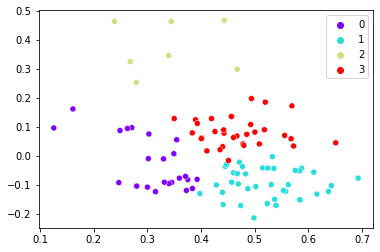

In [9]:
sns.scatterplot(x=X_lsa[:,0], y=X_lsa[:,1], hue=kmeans_2,palette="rainbow")

<AxesSubplot:>

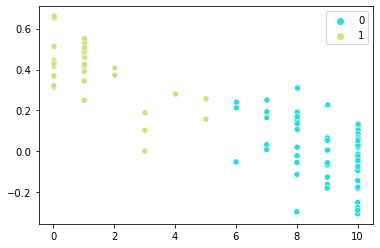

In [10]:
sns.scatterplot(x=X_review_lsa[:,0], y=X_review_lsa[:,1], hue=kmeans_3,palette="rainbow")

### **Visualizing KMeans Clusters**

* **Source (for WordCloud)**: https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d

In [68]:
print(type(review_results_df))
print(review_results_df)
print('-'*80)
print(type(title_results_df))
print(title_results_df)

<class 'pandas.core.frame.DataFrame'>
    cluster                                             review
0         3  Let me start off by saying that the movie's pa...
1         0  Alien is the pinnacle of sci-fi horror, and it...
2         1  I can never pick a favorite movie because diff...
3         3  Twelve Monkeys is a science fiction movie dire...
4         0  simply wonderful on every level. A matrix meet...
..      ...                                                ...
95        0  I was looking forward to seeing " Source Code ...
96        3  one bored Sunday afternoon i thought i would b...
97        1  * 1/2 star out of ****Keep in mind Steven Spie...
98        2  I was so EXCITED to see this movie. After I sa...
99        1  This movie is the beginning of the culmination...

[100 rows x 2 columns]
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
                                 title  cluster
0              

Cluster: 0
Titles: ['Alien', 'Dark City', 'Annihilation', 'Blade Runner 2049', 'They Live', 'Scanners', 'Contact', 'Her', 'War for the Planet of the Apes', 'Face/Off', "Logan's Run", 'Terminator 2: Judgment Day', 'Edge of Tomorrow', 'Contagion', 'Men in Black', 'Star Wars: Episode III - Revenge of the Sith', '2010: The Year We Make Contact', 'Jurassic Park', 'Escape from New York', 'Overlord', 'Inception', 'Ex Machina', 'Source Code']


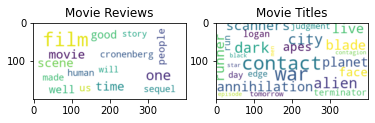

Cluster: 1
Titles: ['Star Wars: Episode IV - A New Hope', 'Arrival', 'Blade Runner', 'Gattaca', 'Moon', 'Aliens', 'Donnie Darko', 'Interstellar', 'The Martian', 'Dredd', 'A Clockwork Orange', 'Children of Men', 'Rise of the Planet of the Apes', 'Sunshine', 'Star Trek', 'The Dead Zone', 'Pitch Black', 'Repo Man', 'WALL·E', 'Under the Skin', 'Men in Black', 'Never Let Me Go', 'Pacific Rim', 'Galaxy Quest', 'V for Vendetta', 'Starman', 'Attack the Block', 'Alien: Covenant', 'Equilibrium', 'Chronicle', 'Predator', 'Cube', 'Demolition Man', 'Super 8', 'Soylent Green', 'Looper', 'Close Encounters of the Third Kind', 'Avengers: Infinity War']


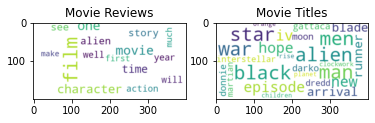

Cluster: 2
Titles: ['Upgrade', 'The Prestige', 'Eternal Sunshine of the Spotless Mind', 'The Truman Show', 'Overlord', 'Ghostbusters', 'Avengers: Endgame']


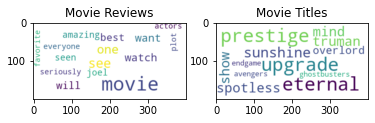

Cluster: 3
Titles: ['Ad Astra', '12 Monkeys', 'Mad Max: Fury Road', '2001: A Space Odyssey', 'Total Recall', 'The Terminator', 'Mad Max 2: The Road Warrior', 'District 9', 'The Cabin in the Woods', 'Unbreakable', 'Primer', '10 Cloverfield Lane', 'Back to the Future', 'The Matrix', 'Midnight Special', 'RoboCop', 'Predestination', 'Solaris', 'Elysium', 'Cloud Atlas', 'Snowpiercer', 'Star Wars: Episode VI - Return of the Jedi', 'The Hidden', 'The Manchurian Candidate', 'Upstream Color', 'Star Trek Into Darkness', 'Cloverfield', 'Coherence', 'Europa Report', 'Back to the Future', 'E.T. the Extra-Terrestrial', 'eXistenZ']


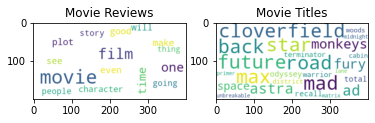

In [76]:
from wordcloud import WordCloud

# WordCloud based on review_text
review_results={'cluster':kmean_labels,'review':df_reviews}
review_results_df=pd.DataFrame(review_results)

# WordCloud based on the title
kmean_labels=kmeans_2
title_results_df=pd.DataFrame(list(zip(movie_titles,kmean_labels)),columns=['title','cluster'])
title_results_df.head(3)

####### Creating Function to create WordCloud #######
def create_wordcloud(data, k, topic, max_words):
   s = data[data.cluster==k]
   text=s[topic].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=max_words, background_color="white").generate(text)
   return wordcloud   

# for clusters 1 through optimal (k=4)
for k in range(0,4):
   # gets all the review text to generate on 
   review_wordcloud = create_wordcloud(review_results_df, k, 'review', 15)
   title_wordcloud = create_wordcloud(title_results_df, k, 'title', 25)

   # print results
   print('Cluster: {}'.format(k))
   titles=kmean_labels_df[kmean_labels_df.cluster==k]['title']         
   title_test = [i for i in titles]
   print(f'Titles: {title_test}')

   # print WordClouds
   fig, (ax1, ax2) = plt.subplots(1, 2)
   ax1.set_title('Movie Reviews')
   ax1.imshow(review_wordcloud, interpolation="bilinear")
   ax2.set_title('Movie Titles')
   ax2.imshow(title_wordcloud, interpolation="bilinear")
   # plt.axis("off")
   plt.show()

# **Hierarchical Based Clustering w/Agglomerative Clustering**

As a alternative clustering comparison method, we will utilize **AGNES** (Agglomerative Clustering) which is a bottom's up approach by starting with each movie review being a cluster of its own and then merging similar movie reviews into clusters.

### **Sources**:
* https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn


<a name="OptimalAGNES"></a>
### Finding Optimal Number of Clusters using Dendrogram Visualization
The dendrogram graphs the sequences of merges or splits of clusters. If any clusters are merged, the dendrogram joins them in a graph and the height of the join is equal to the "distance between clusters". By looking at the results of the dendrogram, we can see when we cut the tree at the both the y=.35 (red dotted line) and y=.4 (solid blue) with a horizontal line, the difference in number of clusters is at either k=4 (y=.4) or k=5 (y=.35). Since cutting the dendrogram provides better separation using k=5, we will assume the optimal number of clusters in the hierarchical clustering AGNES based approachh is thus 5. 

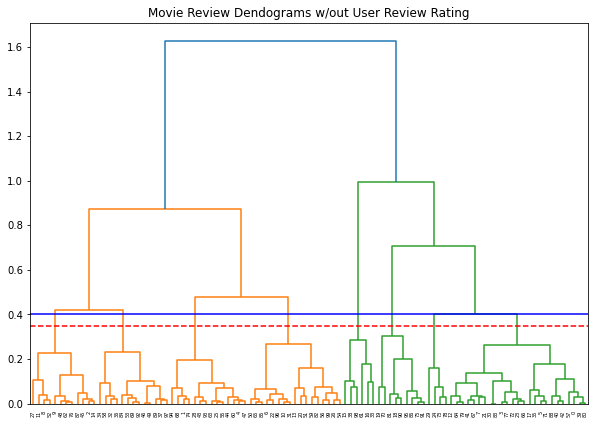

In [37]:
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

#plots dendrogram
plt.figure(figsize=(10, 7))
plt.title("Movie Review Dendograms w/out User Review Rating")
dendrogram(shc.linkage(X_lsa, method='ward'))
plt.axhline(y=0.35, color='r', linestyle='--')
plt.axhline(y=0.4, color='b', linestyle='-')
plt.show()

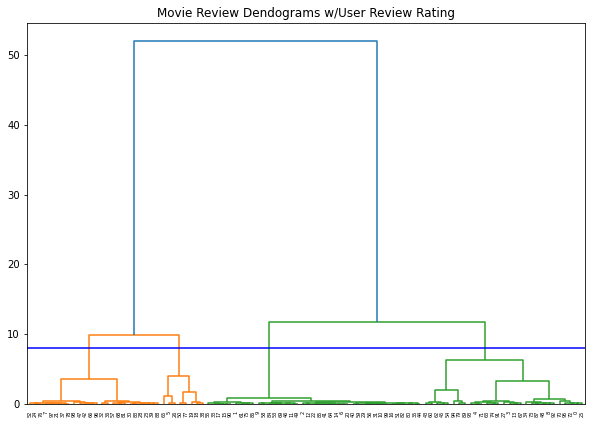

In [41]:
#plots dendrogram
plt.figure(figsize=(10, 7))
plt.title("Movie Review Dendograms w/User Review Rating")
dendrogram(shc.linkage(X_review_lsa, method='ward'))
# plt.axhline(y=0.35, color='r', linestyle='--')
plt.axhline(y=8, color='b', linestyle='-')
plt.show()

In [90]:
from sklearn.cluster import AgglomerativeClustering

def agnes_model(k, data):
    agnes_optimal_k = k
    agnes_clf = AgglomerativeClustering(n_clusters=agnes_optimal_k, affinity='euclidean', linkage='ward')
    agnes_clf.fit_predict(data)

    agnes_label = agnes_clf.labels_
    print(f'AGNES Silhouette Score (k={agnes_optimal_k}): {silhouette_score(data, agnes_clf.labels_):.5f}')
    return agnes_label

print(f'{"-"*10}With LSA Applied{"-"*10}')
# without user review
agnes_1 = agnes_model(2, X_lsa)
agnes_2 = agnes_model(5, X_lsa)

# with user reviews
agnes_3 = agnes_model(2, X_review_lsa)

#### without dimensionality reduction
print(f'\n{"-"*10}Without LSA Applied{"-"*10}')
agnes_nolsa_1 = agnes_model(5, (tfidf_df))
agnes_nolsa_2 = agnes_model(2, (tfdf_review_df))

----------With LSA Applied----------
AGNES Silhouette Score (k=2): 0.37249
AGNES Silhouette Score (k=5): 0.38147
AGNES Silhouette Score (k=2): 0.80764

----------Without LSA Applied----------
AGNES Silhouette Score (k=5): 0.02048
AGNES Silhouette Score (k=2): 0.72871


### **Visualizing AGNES Clustering using Optimal K-Clusters (k=5) and LSA**

<AxesSubplot:>

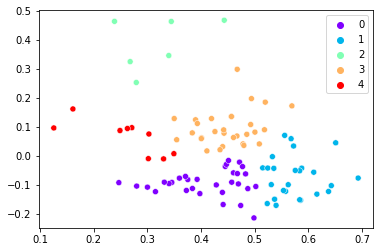

In [78]:
sns.scatterplot(x=X_lsa[:,0], y=X_lsa[:,1], hue=agnes_2,palette="rainbow")

<AxesSubplot:>

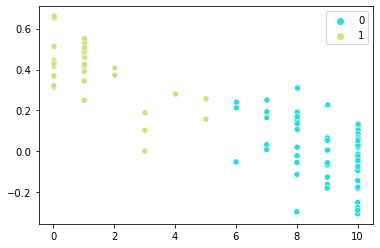

In [82]:
sns.scatterplot(x=X_review_lsa[:,0], y=X_review_lsa[:,1], hue=agnes_3,palette="rainbow")

# **Model Conclusions**
Using the overall silhouette_score as a measurement of cluster fit, we ran the following models and recorded the following scores below. We did this by running 2 optimized clustering models, KMeans and AGNES both with **user review ratings** and without it. Additionaly, for each level of cluster optimization, we ran the model with and without LSA reduction and can see how much of a difference it makes (refer to the 'Without LSA' sections in [Model Results](#ModelResults)). We also observed that by adding in the single user_review_ratings feature, the overall fit doubled. However, though the overall fit doubled by adding in the additional review feature, it came at the expense of reducing the optimal number of clusters. 

We can see this trade-off of cluster separation and number of clusters in the [Model Results](#ModelResults) section below where by first modeling the user review with only it's TF-IDF matrix, the max score using both KMEANS and AGNES was (.40557, .38147), respectively. However, simply by adding in the user review ratings, the max scores doubled for the exact same number of clusters (0.80764, 0.80764). Interestingly, at a much lower number of clusters, regardless of which model we used, the overall cluster separation was the same whether taking a Centroid or Heirarchical clustering approach. 

Overall, since the both model approaches at a lower number of clusters (k=2) were equal, **the KMEANS clustering model was the preferred approach** even though it performed only slightly better with only a fractional difference (0.0241). Additionally, the optimization method for KMEANS is a bit more methodical than arbitrarily cutting the dendrogram across it's tree as discussed in the [Optimizing AGNES](#OptimalAGNES) section where we found that the difference between the 'optimal' cluster was also, arbitrarily ambiguous. 

<a name="ModelResults"></a>
## **Model Results**
* <u>**Without** User Review Ratings:</u>
    * KMeans Silhouette Score (k=2): 0.38557
    * KMeans Silhouette Score (k=4): 0.40557
        * **Without LSA**: KMeans Silhouette Score (k=4): 0.02421
    * AGNES Silhouette Score (k=2): 0.37249
    * AGNES Silhouette Score (k=5): 0.38147
        * **Without LSA**: AGNES Silhouette Score (k=5): 0.02048
* <u>**With** User Review Ratings:</u>
    * KMeans Silhouette Score (k=2): 0.80764
        * **Without LSA**: KMeans Silhouette Score (k=2): 0.72871
    * AGNES Silhouette Score (k=2): 0.80764
        * **Without LSA**: AGNES Silhouette Score (k=2): 0.72871


# **Model Semantics**
To understaned what each of the clusters are centered on, we will utilize a WordCloud that can provide insight into what are the popular words in each cluster. These 'popular words' can be interpreted as the cluster "centers" as what makes them popular is the relevancy of a word in the  TF-IDF matrix. To create the WordCloud, we will utilize the best performing K-Means model (k=4) excluding 'review ratings' for greater granularity into the details of the cluster centers and then only output the top 10 word in each cluster.

* Cluster 0 and 1: We can see from the Movie Reviews WordCloud that Cluster 0 and 1 are both for **films**. The differences between Clusters 0 and 1 could possibly be that Cluster 0 contains mostly about "people" whereas Cluster 1 is more about "aliens".
* Cluster 2 and 3: We can see from the Movie Reviews WordCloud that Cluster 2 and 3 are both for **movies**. The seperation between Clusters 2 and 3 are not as obvious but it can be assumed based on the Movie Title WordCloud that Cluster 2 is more about the "actors" in the movie (ex. "Eternal Sunshine of the Spotless Mind") and Cluster 3 is more about the "plot".
